# Librairies utilisées

In [33]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import spacy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
import re

# Importation du fichier csv

In [35]:
debats = pd.read_csv("debats.csv", sep=",")
debats.head()

,Unnamed: 0,dateSeance,texte,groupe_politique
0,0,20190115150000000,"Prochaine séance, ce soir, à vingt et une heur...",LaREM
1,1,20190115150000000,\n \nLe Directeur du service du com...,NaN
2,2,20190115150000000,"Monsieur le Premier ministre, comme vous le sa...",NaN
3,3,20190115150000000,"Il appartiendra donc aux parlementaires ou, pl...",NaN
4,4,20190115150000000,"Dans cet esprit, pourquoi avoir refusé un chan...",SOC


# Pré-traitement des données

## Suppression colonne Unnamed, et des NaN dans groupe_politique

In [36]:
debats.drop
debats.dropna(axis=0, how='any', inplace=True)  
debats.reset_index(drop=True, inplace=True)
debats.drop('Unnamed: 0', inplace=True, axis=1)
print(debats.iloc[:5,])
print(len(debats))

          dateSeance  ... groupe_politique
0  20190115150000000  ...            LaREM
1  20190115150000000  ...              SOC
2  20190115150000000  ...               NI
3  20190115150000000  ...               FI
4  20190115150000000  ...              SOC

[5 rows x 3 columns]
53564


In [37]:
#On cree une nouvelle colonne 'etiquette' qui a les memes valeurs que 'groupe politique'
debats['orientation'] = debats['groupe_politique']
#On remplace dans la colonne 'etiquette' les valeurs 'LR' par 'droite' et les valeurs
#'SOC', 'GDR', et 'FI' par 'gauche
debats['orientation'] = debats['orientation'].replace(['LR', 'SOC', 'GDR', 'FI'], ['droite', 'gauche', 'gauche', 'gauche'])


#Pour notre dataframe, nous choisissons uniquement les lignes qui ont comme etiquette
#'gauche' ou 'droite' et on reindexe à la fin de la selection
debats = debats[debats['orientation'].isin(['gauche', 'droite'])]
debats.reset_index(drop=True, inplace=True)

In [38]:
#On enleve la colonne groupe_politique
debats.drop('groupe_politique', inplace=True, axis=1)
debats.head()

,dateSeance,texte,orientation
0,20190115150000000,"Dans cet esprit, pourquoi avoir refusé un chan...",gauche
1,20190115150000000,"Le pompier qui est dans le coma, ce n’est pas ...",gauche
2,20190115150000000,Vous en savez quelque chose !,gauche
3,20190115150000000,Le groupe La France insoumise ne désespère pas...,gauche
4,20190115150000000,Le groupe de la Gauche démocrate et républicai...,gauche


## Transformation de la colonne dateSeance : on ne gardera que l'année (pour la partie Solr)

In [39]:
from textwrap import wrap
# Pour la partie 2 Solr, on a du changé le format de la date, pour ne laisser que l'année
res = []

for i in debats['dateSeance']:
   new = wrap(str(i), 4) # on garde les 4 premiers chiffres qui corespond à l'année
   res.append(new[0])

res = list(map(int, res))
debats['dateSeance'] = res

In [40]:
debats.head()

,dateSeance,texte,orientation
0,2019,"Dans cet esprit, pourquoi avoir refusé un chan...",gauche
1,2019,"Le pompier qui est dans le coma, ce n’est pas ...",gauche
2,2019,Vous en savez quelque chose !,gauche
3,2019,Le groupe La France insoumise ne désespère pas...,gauche
4,2019,Le groupe de la Gauche démocrate et républicai...,gauche


In [41]:
debats.to_csv('debats_transfo.csv', sep = ',', index=False)

In [42]:
#On separe les données en attributs et cibles
X = debats[['dateSeance', 'texte']]
y = debats.orientation

In [43]:
#On separe les données en données de train et données de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True)

In [44]:
X_train.head()

,dateSeance,texte
796,2018,Voulons-nous à tout prix être livrés en vingt-...
14395,2020,"Prochaine séance, ce soir, à vingt et une heur..."
8993,2018,Nous connaissons tous au moins une histoire tr...
11463,2020,C’est faux.
21180,2017,Si !


# Construction du modèle

## Importation des librairies pour la tokenization et la lemmatisation

In [45]:
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize, WhitespaceTokenizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')


wn = WordNetLemmatizer()
w_tokenizer = WhitespaceTokenizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pré-traitement de la colonne texte et création du pipeline

In [46]:
# Classe pour sélectionner des colonnes à partir de leur nom
class SingleColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, data_dict):
        return data_dict[self.key]

In [47]:
# Tokenization puis lemmatisation avant le transformation en vecteur

def split_into_tokens_lemmatized_nltk(text) :
    result = "".join([word for word in text if word not in string.punctuation])
    tokens = re.split('\W', result)
    tmp = [word for word in tokens if word not in fr_stopwords]
    new = [wn.lemmatize(word) for word in tmp]
    return tmp

# Liste des mots vides de NLTK + signes de ponctuation
fr_stopwords = stopwords.words('french')

# Objet TfidfVectorizer
text_vectorizer = TfidfVectorizer(tokenizer=split_into_tokens_lemmatized_nltk, 
                                lowercase=True, 
                                stop_words=fr_stopwords,
                                min_df=0.01)

# Pipeline spécifique à la colonne texte
texte_pipeline = make_pipeline(
    SingleColumnSelector(key="texte"),
    text_vectorizer
)

# Application de la pipeline à X_train ('apprentissage' du vocabulaire pour la colonne texte)
texte_pipeline.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:507: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Pipeline(memory=None,
         steps=[('singlecolumnselector', SingleColumnSelector(key='texte')),
                ('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=0.01, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=['au', 'aux', 'avec', 'ce', 'ces',
                                             'dans', 'de', 'des', 'du', 'elle',
                                             'en', 'et', 'eux', 'il', 'ils',
                                             'je', 'la', 'le', 'les', 'leur',
                                             'lui', 'ma', 'mais', 'me', '

In [48]:
# Exemple d'application de la pipeline pour transformer les 5 premières instances de X_test
res = texte_pipeline.transform(X_test.head())
print("Input text")
print(X_test.texte.head())
print()
print("Output bags of words")
# Affichage des traits extraits par la pipeline
bow = pd.DataFrame(res.toarray(), columns=text_vectorizer.get_feature_names())
bow.set_index(X_test.head().index, inplace=True)
bow.replace(0, np.nan).dropna(axis=1, how='all').fillna(0)

Input text
6748     Cependant, j’appelle votre attention sur le fa...
14991                                C’est le brouillard !
23775    C’est une réalité – ce qui n’empêche en rien q...
19675                                  C’est une réalité !
9368              Où sont passés les 70 millions d’euros ?
Name: texte, dtype: object

Output bags of words


,,ainsi,amendement,appelle,application,après,attention,autant,autre,bon,cadre,car,cas,celui,cependant,certaines,certains,cette,comptes,contrôle,coût,devrait,difficulté,dont,déjà,euros,existe,fait,gouvernement,hier,loi,matin,millions,ministre,mois,moment,monsieur,obtenir,outre,où,parlementaires,peut,plus,points,premier,preuve,problème,présent,question,questions,quoi,rapport,respect,rien,réalité,réponses,sans,si,soutenir,sujet,sûr,très,être
6748,0.038748,0.123964,0.000000,0.185151,0.00000,0.143823,0.182879,0.000000,0.137005,0.150172,0.000000,0.127493,0.132035,0.148102,0.178632,0.157543,0.000000,0.092053,0.372691,0.000000,0.000000,0.173428,0.184762,0.000000,0.130391,0.000000,0.167079,0.106272,0.116358,0.000000,0.000000,0.000000,0.000000,0.000000,0.292805,0.161519,0.00000,0.189304,0.16802,0.00000,0.000000,0.124299,0.090669,0.000000,0.000000,0.000000,0.149842,0.000000,0.000000,0.155327,0.164117,0.000000,0.00000,0.000000,0.000000,0.187165,0.117481,0.209777,0.185677,0.137233,0.17224,0.000000,0.104029
14991,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
23775,0.142297,0.000000,0.128647,0.000000,0.21241,0.000000,0.000000,0.184178,0.000000,0.000000,0.185486,0.156066,0.000000,0.000000,0.000000,0.000000,0.173707,0.112684,0.000000,0.216602,0.213683,0.000000,0.000000,0.145209,0.000000,0.000000,0.000000,0.000000,0.142436,0.231551,0.127025,0.235298,0.000000,0.126858,0.000000,0.000000,0.13573,0.000000,0.00000,0.00000,0.213566,0.000000,0.110990,0.226328,0.170412,0.222252,0.000000,0.199699,0.146128,0.000000,0.000000,0.172358,0.22001,0.173253,0.190681,0.229112,0.000000,0.000000,0.000000,0.167989,0.00000,0.122161,0.000000
19675,0.241395,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.970427,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
9368,0.161084,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.552556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.610402,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.54419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


In [49]:
#Affichage du nombre de traits générés par chacune des chaines 
fnames_text = texte_pipeline.named_steps['tfidfvectorizer'].get_feature_names()
print('Nombres de traits extraits à partir de la colonne texte :', len(fnames_text))

Nombres de traits extraits à partir de la colonne texte : 790


## Tests de différents algorithmes d'apprentissage

### Multinomial

In [50]:
# Prétraitement + apprentissage
classifier_pipeline_mult = make_pipeline(
    # Préparation des données pour l'apprentissage
    texte_pipeline,
    # Algorithme d'apprentissage
    MultinomialNB()
)
# Apprentissage avec les données d'entraînement
classifier_pipeline_mult.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('singlecolumnselector',
                                  SingleColumnSelector(key='texte')),
                                 ('tfidfvectorizer',
                                  TfidfVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.float64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=None,
                                                  min_df=0.01,
                                                  ngram_range=(1, 1), n...
                                                              'leur', 'lui

In [51]:
all_predictions_mult = classifier_pipeline_mult.predict(X_test)
print(all_predictions_mult)

['droite' 'droite' 'droite' ... 'gauche' 'gauche' 'droite']


In [52]:
# precision du classifier
acc_mult = accuracy_score(y_test, all_predictions_mult)
print('Précision du classifier avec l\'algorithme Multinomial', accuracy_score(y_test, all_predictions_mult))

Précision du classifier avec l'algorithme Multinomial 0.6043360433604336


Text(0.5, 0, 'predicted label')

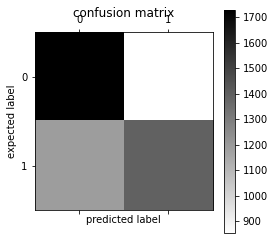

In [53]:
plt.matshow(confusion_matrix(y_test, all_predictions_mult), 
            cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

### Randomclassifier

In [54]:
classifier_pipeline_rand = make_pipeline(
    # Préparation des données pour l'apprentissage
    texte_pipeline,
    # Algorithme d'apprentissage
    RandomForestClassifier()
)
# Apprentissage avec les données d'entraînement
classifier_pipeline_rand.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('pipeline',
                 Pipeline(memory=None,
                          steps=[('singlecolumnselector',
                                  SingleColumnSelector(key='texte')),
                                 ('tfidfvectorizer',
                                  TfidfVectorizer(analyzer='word', binary=False,
                                                  decode_error='strict',
                                                  dtype=<class 'numpy.float64'>,
                                                  encoding='utf-8',
                                                  input='content',
                                                  lowercase=True, max_df=1.0,
                                                  max_features=None,
                                                  min_df=0.01,
                                                  ngram_range=(1, 1), n...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
   

In [55]:
all_predictions_rand = classifier_pipeline_rand.predict(X_test)
print(all_predictions_rand)

['droite' 'droite' 'droite' ... 'gauche' 'droite' 'droite']


In [56]:
acc_rand = accuracy_score(y_test, all_predictions_rand)
print('Précision pour l\'algorithme d\'apprentissage RandomClassifier', acc_rand)

Précision pour l'algorithme d'apprentissage RandomClassifier 0.6329849012775842


Text(0.5, 0, 'predicted label')

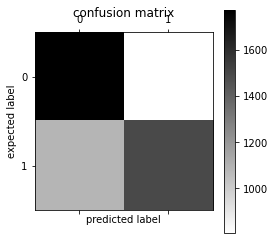

In [57]:
plt.matshow(confusion_matrix(y_test, all_predictions_rand), 
            cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

## Validation croisée stratifiée

In [58]:
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True)

#### Multinomial avec validation croisée stratifiée

In [59]:
# Avec Validation croisée stratifiée
model_pipeline_mult = make_pipeline(texte_pipeline,MultinomialNB())
y_pred_mult = model_selection.cross_val_predict(model_pipeline_mult, X, y, 
                                               cv=kfold)

print(y_pred_mult)

['gauche' 'droite' 'gauche' ... 'gauche' 'droite' 'droite']


In [60]:
acc_cross_mult = accuracy_score(y, y_pred_mult)
print('Précision avec validation croisée stratifiée : ', acc_cross_mult)

Précision avec validation croisée stratifiée :  0.6059620596205962


In [61]:
print(classification_report(y, y_pred_mult))

              precision    recall  f1-score   support

      droite       0.60      0.68      0.63     12997
      gauche       0.62      0.53      0.57     12833

    accuracy                           0.61     25830
   macro avg       0.61      0.61      0.60     25830
weighted avg       0.61      0.61      0.60     25830



Text(0.5, 0, 'predicted label')

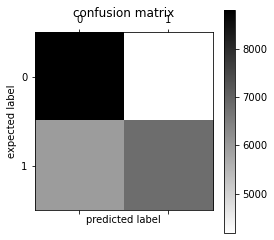

In [62]:
plt.matshow(confusion_matrix(y, y_pred_mult), 
            cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

#### RandomClassifier avec validation croisée stratifiée

In [63]:
model_pipeline_rand = make_pipeline(texte_pipeline,RandomForestClassifier())
y_pred_rand = model_selection.cross_val_predict(model_pipeline_rand, X, y, 
                                               cv=kfold)
print(y_pred_rand)


['droite' 'droite' 'droite' ... 'gauche' 'gauche' 'droite']


In [64]:
# precision du classifier
acc_cross_rand = accuracy_score(y, y_pred_rand)
print('Précision avec validation croisée stratifiée : ', acc_cross_rand)

Précision avec validation croisée stratifiée :  0.6356174990321332


In [65]:
print(classification_report(y, y_pred_rand))

              precision    recall  f1-score   support

      droite       0.63      0.68      0.65     12997
      gauche       0.64      0.59      0.62     12833

    accuracy                           0.64     25830
   macro avg       0.64      0.64      0.63     25830
weighted avg       0.64      0.64      0.63     25830



Text(0.5, 0, 'predicted label')

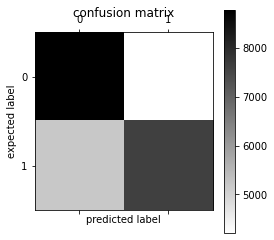

In [66]:
plt.matshow(confusion_matrix(y, y_pred_rand), 
            cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

## Comparaison des modèles 

### Sans validation croisée

In [67]:
scores= []
scores.append(acc_mult)
scores.append(acc_rand)

names = ['Multinomial', 'RandomClassifier']
scoring = 'accuracy'

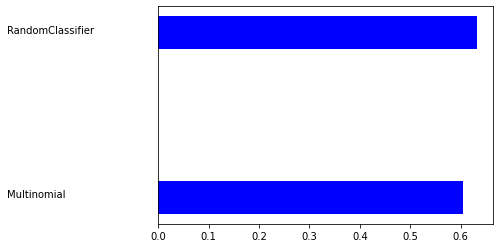

In [68]:
indices = np.arange(len(scores))
fig = plt.figure()
plt.barh(indices, scores, .2, label="score", color='b')
plt.yticks(())
for i, c in zip(indices, names):
    plt.text(-.3, i, c)
plt.show()

### Avec validation croisée

In [69]:
scores_cross = []
scores_cross.append(acc_cross_mult )
scores_cross.append(acc_cross_rand)

names = ['Multinomial', 'RandomClassifier']
scoring = 'accuracy'

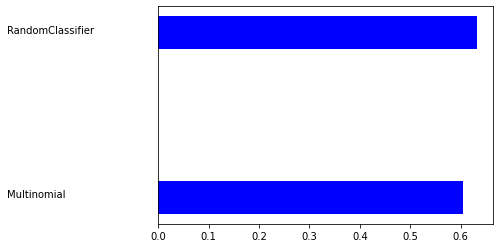

In [70]:
indices = np.arange(len(scores_cross))
fig = plt.figure()
plt.barh(indices, scores, .2, label="score", color='b')
plt.yticks(())
for i, c in zip(indices, names):
    plt.text(-.3, i, c)
plt.show()